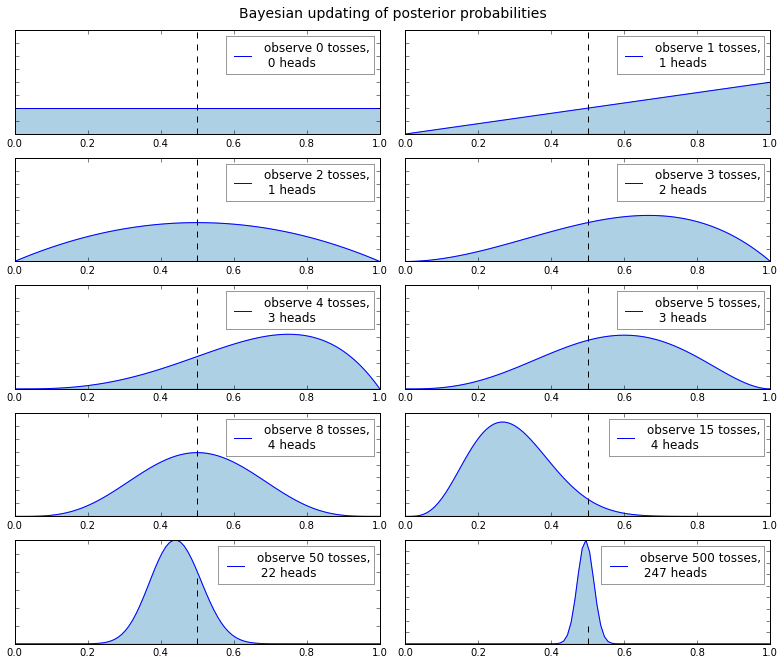

In [38]:
# basically, just copy pasting 
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt 
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(.5, size = n_trials[-1])
x = np.linspace(0, 1, 100)

for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials) / 2, 2, k + 1)
#    plt.xlabel("$p$, probability of heads") 
 #       if k in [0, len(n_trials) - 1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label = "observe %d tosses, \n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color = "#348ABD", alpha = 0.4)
    plt.vlines(.5, 0, 4, color = "k", linestyles = "--", lw = 1)
    leg = plt.legend()
    leg.get_frame().set_alpha(.4)
    plt.autoscale(tight = True)
    
plt.suptitle("Bayesian updating of posterior probabilities",
            y = 1.02,
            fontsize = 14)

plt.tight_layout()

<Container object of 16 artists>

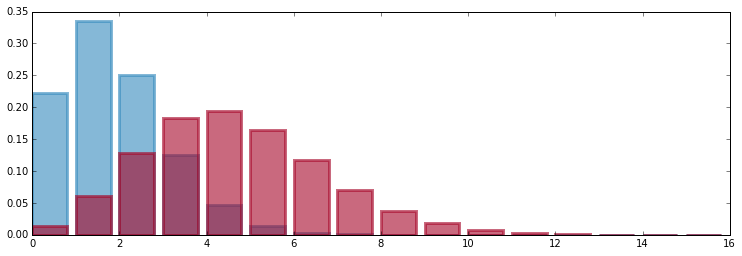

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt 

figsize(12.5, 4)

import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25]
colours = ["#348ABD", "#A60628"]

plt.bar(a, poi.pmf(a, lambda_[0]), color = colours[0],
       label = "$\lambda = %.1f$" % lambda_[0], alpha = .6,
       edgecolor = colours[0], lw = "3")

plt.bar(a, poi.pmf(a, lambda_[1]), color = colours[1],
       label = "$\lambda = %.1f$" % lambda_[1], alpha = .6,
       edgecolor = colours[1], lw = "3")

In [3]:
count_data = np.loadtxt("txtdata.csv")
n_count_data = len(count_data)

import pymc as pm

alpha = 1 / count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper = n_count_data)

print tau.random()


70


In [4]:
@pm.deterministic

def lambda_(tau=tau, lambda_1=lambda_1, lambda_2 = lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

In [10]:
# the following line defines the observation, as a vector of poisson variables
# with charactersitics from lambda_ (that there are two parameters explaining
# different parts of data here). It also links this to the value=count_data.
# This is what I know for now! 

observation = pm.Poisson("obs", lambda_, value= count_data, observed = True)

# the model, is a bayesian model now. We know that observation is trying to model 
# our value=count_data with defined characteristics as above. Now that it is 
# the actual model, it also gives lambda_1, lambda_2 and tau to it
model = pm.Model([observation, lambda_1, lambda_2, tau])
observation.value[1:10]

array([24,  8, 24,  7, 35, 14, 11, 15, 11])

In [6]:
# still trying to figure this out. All this can be done manually and I am not sure
# what is the .MCMC doing with the model. 

mcmc = pm.MCMC(model)

In [9]:
help(pm.MCMC)

Help on class MCMC in module pymc.MCMC:

class MCMC(pymc.Model.Sampler)
 |  This class fits probability models using Markov Chain Monte Carlo. Each stochastic variable
 |  is assigned a StepMethod object, which makes it take a single MCMC step conditional on the
 |  rest of the model. These step methods are called in turn.
 |  
 |    >>> A = MCMC(input, db, verbose=0)
 |  
 |    :Parameters:
 |      - input : module, list, tuple, dictionary, set, object or nothing.
 |          Model definition, in terms of Stochastics, Deterministics, Potentials and Containers.
 |          If nothing, all nodes are collected from the base namespace.
 |      - db : string
 |          The name of the database backend that will store the values
 |          of the stochastics and deterministics sampled during the MCMC loop.
 |      - verbose : integer
 |          Level of output verbosity: 0=none, 1=low, 2=medium, 3=high
 |  
 |  Inherits all methods and attributes from Model. Subclasses must define the _l